# Introdução

Esse projeto será dividido em 2 partes principais, na primeira irei analisar algumas hipóteses pré-definidas pelo time de marketing de uma grande loja online e irei escolher quais serão priorizadas com o intuito de aumentar a receita da loja.

Na segunda parte irei realizar um teste A/B e analisar os resultados.

# Carregando e preparando os dados: 

In [1]:
#Importando as bibliotecas necessárias para a análise

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

In [2]:
#Carregando as bases de dados que serão usadas na análise

df_hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
df_orders = pd.read_csv('/datasets/orders_us.csv')
df_visits = pd.read_csv('/datasets/visits_us.csv')

# Pré Processamento de dados:

## df_hypotheses

In [3]:
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [4]:
#Visualizando as informações básicas do df_hypotheses
df_hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Pude analisar inicialmente que o df_hypotheses não possuí dados duplicados e o tipo dos dados está de acordo. 

Porém os dados não estão separados por colunas, e sim por ';' , mas já corrigi isso usando o sep=';' na hora de carregar a base de dados.

## df_orders

In [5]:
df_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [6]:
#Descartando possiveis dados duplicados no df_orders

df_orders = df_orders.drop_duplicates()

In [7]:
#Visualizando as informações básicas do df_orders

df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 56.1+ KB


In [8]:
#Visualizando estatísticas básicas no df_orders

df_orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1197.000000
mean,2.155621e+09,2.165960e+09,131.491646
std,1.229085e+09,1.236014e+09,603.004729
min,1.062393e+06,5.114589e+06,5.000000
25%,1.166776e+09,1.111826e+09,20.800000
50%,2.145194e+09,2.217985e+09,50.200000
75%,3.237740e+09,3.177606e+09,130.400000
max,4.293856e+09,4.283872e+09,19920.400000


In [9]:
#Alterando o tipo dos dados na coluna 'date' para DateTime

df_orders['date'] = pd.to_datetime(df_orders['date'])

Sabendo que o mesmo usuário não pode pertencer aos dois grupos (A e B), irei identificar os usuários que estão em ambos os grupos, e descartá-los para que não afetem os resultados da nossa análise. 

In [10]:
#identificando os usuários que estão presentes em ambos os grupos (A e B).
duplicated_users = df_orders[df_orders.duplicated(subset=['visitorId'], keep=False)]

# Crie uma lista de identificadores de usuário que precisam ser descartados.
users_to_remove = duplicated_users['visitorId'].unique()

# Descarte os usuários presentes em ambos os grupos (A e B) do DataFrame original.
df_orders = df_orders[~df_orders['visitorId'].isin(users_to_remove)]

In [11]:
#testando se funcionou
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  937 non-null    int64         
 1   visitorId      937 non-null    int64         
 2   date           937 non-null    datetime64[ns]
 3   revenue        937 non-null    float64       
 4   group          937 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 43.9+ KB


Podemos observar que haviam muitos usuários que estavam em ambos os grupos (A e B) no df_orders.
Agora, sem esses usuários duplicados, podemos realizar nossa análise de maneira mais acertiva. 

## df_visits

In [12]:
df_visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [13]:
#Descartando possiveis dados duplicados no df_visits

df_visits = df_visits.drop_duplicates()

In [14]:
#Visualizando as informações básicas do df_visits

df_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


In [15]:
#Alterando o tipo dos dados na coluna 'date' para DateTime

df_visits['date'] = pd.to_datetime(df_visits['date'])

In [16]:
#Visualizando estatísticas básicas no df_visits

df_visits.describe()

,visits
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


A principio podemos observar que não existem dados duplicados ou valores anormais no df_visits.
O tipo dos dados também estão de acordo, após corrigir a coluna 'date'. 

In [17]:
#Ordenando os valores por data para melhorar a visualização

df_visits.sort_values(by='date')

,date,group,visits
0,2019-08-01,A,719
31,2019-08-01,B,713
1,2019-08-02,A,619
32,2019-08-02,B,581
2,2019-08-03,A,507
...,...,...,...
28,2019-08-29,A,577
60,2019-08-30,B,490
29,2019-08-30,A,490
30,2019-08-31,A,699


<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Excelente trabalho checando a consistência dos dados.

Sempre importante para garantir uma análise robusta!
</div>




# PARTE 1 - Priorizando Hipóteses

In [18]:
#Aplicando o framework ICE para priorizar hipóteses. Classificando em ordem decrescente de prioridade.

#Calculando o score ICE para cada hipótese.
df_hypotheses['ICE'] = (df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']

#Classificando as hipóteses em ordem decrescente de prioridade com base no score ICE.
hypotheses_ice = df_hypotheses.sort_values(by='ICE', ascending=False)

hypotheses_ice

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000


In [19]:
#Aplicando o framework RICE para priorizar hipóteses. Classificando em ordem decrescente de prioridade.

#Calculando o score RICE para cada hipótese.
df_hypotheses['RICE'] = (df_hypotheses['Reach'] * df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']

#Classificando as hipóteses em ordem decrescente de prioridade com base no score RICE.
hypotheses_rice = df_hypotheses.sort_values(by='RICE', ascending=False)

hypotheses_rice

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


In [20]:
df_hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hypothesis  9 non-null      object 
 1   Reach       9 non-null      int64  
 2   Impact      9 non-null      int64  
 3   Confidence  9 non-null      int64  
 4   Effort      9 non-null      int64  
 5   ICE         9 non-null      float64
 6   RICE        9 non-null      float64
dtypes: float64(2), int64(4), object(1)
memory usage: 632.0+ bytes


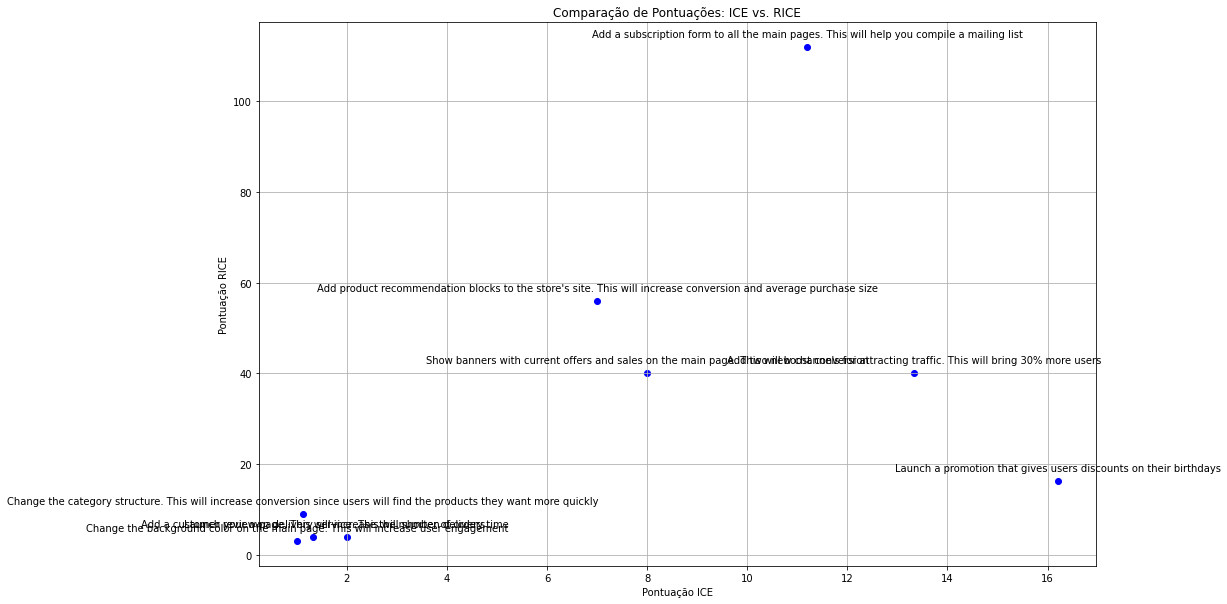

In [21]:
#Dados das hipóteses e suas pontuações de ICE e RICE
hipoteses = df_hypotheses['Hypothesis']
ice_scores = df_hypotheses['ICE']
rice_scores = df_hypotheses['RICE']

#Criando um gráfico de dispersão comparando ICE e RICE
plt.figure(figsize=(15, 10))
plt.scatter(ice_scores, rice_scores, color='blue', marker='o')

#Adicionando rótulos para as hipóteses
for i, hipotese in enumerate(hipoteses):
    plt.annotate(hipotese, (ice_scores[i], rice_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

#Adicionando rótulos dos eixos
plt.xlabel('Pontuação ICE')
plt.ylabel('Pontuação RICE')

#Título e grade
plt.title('Comparação de Pontuações: ICE vs. RICE')
plt.grid(True)


plt.show()

No gráfico acima podemos ver claramente a diferença na priorização usando RICE e ICE.

Aplicando a metodologia RICE a melhor hipotese seria "Adicionar uma assinatura para todas as páginas principais, isso ajudará a compilar uma lista de correspondencia" 

Enquanto a metodologia ICE diz que a melhor hipotese seria "Lançar uma promoção que dê descontos aos usuários no dia de seus aniversários" 

Entre todas as hipoteses estudadas, as que podem se enquadrar em um 'meio termo' entre as duas metodologias, são: "adicionar blocos de recomendação de produtos ao site da loja." e "adicionar dois novos canais para atrair tráfego.

A priorização das hipóteses muda significativamente quando se utiliza o framework RICE em vez de ICE, por conta da inclusão do fator "Reach" (Alcance) no cálculo do score. 

Usando o framework RICE em vez de ICE priorizamos hipóteses que têm um potencial de impacto mais amplo, levando em consideração o alcance e a confiança, além do impacto e esforço. 

Isso é útil para projetos em que a amplitude do público afetado é crítica e pode resultar em mudanças estratégicas significativas na receita da nossa loja online. 

A inclusão do "Reach" torna o RICE uma abordagem mais abrangente e orientada para o impacto em toda a organização.

# PARTE 2 - Análise de teste A/B

Foi realizado um teste A/B que obteve os resultados descritos nos arquivos orders_us.csv e visitors_us.csv.

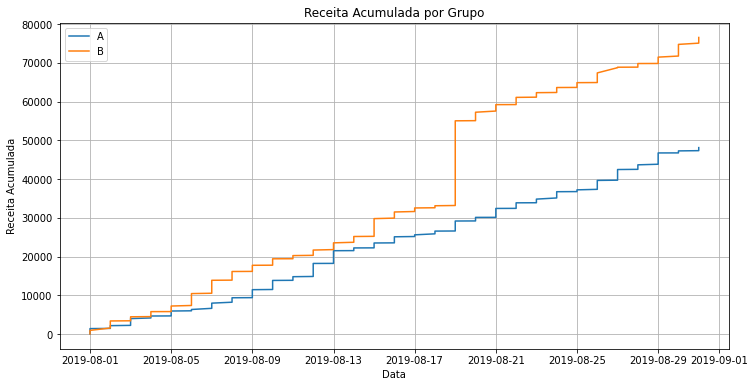

In [22]:
#Criando um gráfico da receita acumulada por grupo. 

#Combinando os DataFrames com base nas datas e grupos
data = df_orders.merge(df_visits, on=['date', 'group'], how='left')

#Calculando a receita acumulada para cada grupo e data
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['date', 'group'])
data['cumulative_revenue'] = data.groupby('group')['revenue'].cumsum()

#Criando o gráfico
plt.figure(figsize=(12, 6))
for group in data['group'].unique():
    group_data = data[data['group'] == group]
    plt.plot(group_data['date'], group_data['cumulative_revenue'], label=group)

plt.title('Receita Acumulada por Grupo')
plt.xlabel('Data')
plt.ylabel('Receita Acumulada')
plt.legend()
plt.grid()
plt.show()

Diferença no Desempenho dos Grupos A e B: Pode-se notar uma diferença entre os grupos A e B em termos de receita acumulada ao longo do tempo. O grupo B teve um grande aumento da receita a partir do dia 17/08/2019, se distanciando bastante do outro grupo, enquanto o grupo A seguiu aumentando mas sem nenhum crescimento anormal. 

Variação Inicial: No início do teste A/B, os dois grupos parecem ter uma receita acumulada semelhante. Isso é normal, já que o teste é iniciado com o mesmo tratamento para ambos os grupos.

Picos e Quedas: O pico brusco na receita acumulada entre os dias 17/08 e 21/08 deve ser investigado. Pode ser resultado de ações específicas, mudanças de design no site, promoções, ou outros fatores que afetaram o comportamento dos usuários.

Estabilidade: Ambos os grupos mostram uma tendência de crescimento constante e estável ao longo do tempo, isso pode ser um sinal de consistência nas melhorias e estratégias.



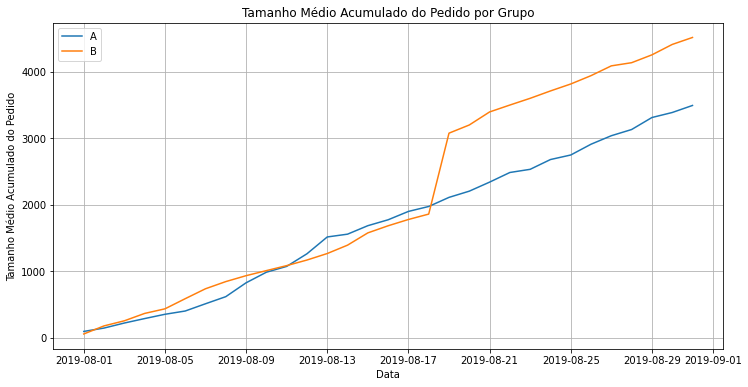

In [23]:
#Criando um gráfico do tamanho médio acumulado do pedido por grupo.

#Agrupando os dados em df_orders por grupo e data, calcule a receita média e acumule os valores.
grouped_orders = df_orders.groupby(['group', 'date'])['revenue'].mean().groupby('group').cumsum().reset_index()

#combinando os dataframes de receita acumulada e visitas por data e grupo.
df_combined = pd.merge(df_visits, grouped_orders, on=['group', 'date'])

#Crindo um gráfico de linha para o tamanho médio acumulado do pedido por grupo.
plt.figure(figsize=(12, 6))
for group in df_combined['group'].unique():
    group_data = df_combined[df_combined['group'] == group]
    plt.plot(group_data['date'], group_data['revenue'], label=group)

plt.xlabel('Data')
plt.ylabel('Tamanho Médio Acumulado do Pedido')
plt.title('Tamanho Médio Acumulado do Pedido por Grupo')
plt.legend()
plt.grid(True)
plt.show()

O gráfico exibe duas linhas, uma para o grupo A e outra para o grupo B. Comparando as duas linhas, podemos interpretar que ambos os grupos tiveram um crescimento contínuo no tamanho médio acumulado dos pedidos. 
Entre os dias 18/08 e 19/08, o grupo B teve um crescimento bem maior, o que indica que a estratégia aplicada nesse periodo foi eficiente. o grupo A não teve o mesmo crecimento, porém seguiu crescendo num ritmo menor. 
Sendo assim eu diria que a mudança feita no grupo B, deve ser aplicada definitivamente, pois deu bons resultados.

Agora vamos observar um gráfico da diferença relativa no tamanho médio acumulado do pedido para o grupo B em comparação com o grupo A.

Diferença Relativa = (Tamanho Médio Acumulado do Pedido no Grupo B - Tamanho Médio Acumulado do Pedido no Grupo A) / Tamanho Médio Acumulado do Pedido no Grupo A

In [24]:
# construir um vetor com valores de pares unívocos de grupos de datas usando o método drop_duplicates()
datesGroups = df_orders[['date', 'group']].drop_duplicates()

# aplicar os métodos np.logical para cada linha do DataFrame (apply(axix=1)) e 
# ordenar os resultados pelas colunas 'date' e 'group'

ordersAggregated = datesGroups.apply(
    lambda x: df_orders[
        np.logical_and(
            df_orders['date'] <= x['date'], df_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitsAggregated = datesGroups.apply(
    lambda x: df_visits[
        np.logical_and(
            df_visits['date'] <= x['date'], df_visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# juntando as duas tabelas em uma e dando nomes descritivos às suas colunas
# buyers — a quantidade de usuários que fazem pelo menos um pedido na data especificada para o grupo especificado
cumulativeData = ordersAggregated.merge(
    visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visits',
]
cumulativeDataA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeDataB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

In [25]:
cumulativeData

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,15,15,1427.4,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,30,30,2189.6,1338
3,2019-08-02,B,37,37,3399.5,1294
4,2019-08-03,A,54,54,4004.8,1845
...,...,...,...,...,...,...
57,2019-08-29,B,472,472,71467.0,17708
58,2019-08-30,A,419,419,47276.2,18037
59,2019-08-30,B,493,493,74753.8,18198
60,2019-08-31,A,427,427,48124.5,18736


In [41]:
cumulativeDataA

,date,revenue,orders,revenue_per_order,conversion_rate,cumulative_conversion_A
0,2019-08-01,1427.4,15,95.160000,0.020862,0.020862
2,2019-08-02,2189.6,30,72.986667,0.022422,0.022422
4,2019-08-03,4004.8,54,74.162963,0.029268,0.029268
6,2019-08-04,4674.6,64,73.040625,0.024980,0.024980
8,2019-08-05,5962.1,84,70.977381,0.025316,0.025316
10,2019-08-06,6356.9,92,69.096739,0.023087,0.023087
12,2019-08-07,7993.6,107,74.706542,0.023115,0.023115
14,2019-08-08,9382.8,120,78.190000,0.022905,0.022905
16,2019-08-09,11467.1,130,88.208462,0.022199,0.022199
18,2019-08-10,13854.6,145,95.548966,0.023156,0.023156


In [27]:
cumulativeDataB

,date,revenue,orders
1,2019-08-01,967.2,17
3,2019-08-02,3399.5,37
5,2019-08-03,4471.1,51
7,2019-08-04,5802.0,63
9,2019-08-05,7251.3,84
11,2019-08-06,10459.0,105
13,2019-08-07,13894.6,128
15,2019-08-08,16159.1,149
17,2019-08-09,17760.0,167
19,2019-08-10,19434.8,189


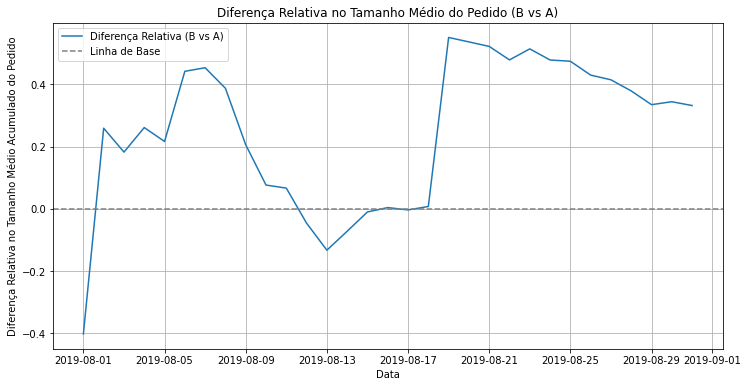

In [28]:
# Calcular a diferença relativa
cumulativeDataA['revenue_per_order'] = cumulativeDataA['revenue'] / cumulativeDataA['orders']
cumulativeDataB['revenue_per_order'] = cumulativeDataB['revenue'] / cumulativeDataB['orders']
cumulativeDataDiff = cumulativeDataA.merge(cumulativeDataB, on='date', suffixes=('_A', '_B'))
cumulativeDataDiff['relative_difference'] = (cumulativeDataDiff['revenue_per_order_B'] / cumulativeDataDiff['revenue_per_order_A']) - 1

# Criar um gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataDiff['date'], cumulativeDataDiff['relative_difference'], label='Diferença Relativa (B vs A)')
plt.axhline(y=0, color='gray', linestyle='--', label='Linha de Base')
plt.xlabel('Data')
plt.ylabel('Diferença Relativa no Tamanho Médio Acumulado do Pedido')
plt.title('Diferença Relativa no Tamanho Médio do Pedido (B vs A)')
plt.legend()
plt.grid(True)
plt.show()

O gráfico mostra variações significativas na diferença relativa entre os grupos B e A ao longo do período de tempo analisado. Isso sugere que o desempenho relativo dos grupos não é constante e pode ser afetado por diferentes fatores em momentos diferentes.

No início do período, a diferença relativa é negativa, indicando que o grupo A tinha um tamanho médio de pedido superior. Mas ao longo do tempo a diferença relativa se torna positiva, o que significa que o grupo B melhorou seu desempenho em relação ao tamanho médio do pedido em comparação com o grupo A.

entre os dias 05/08 e 08/08 o desempenho do grupo B teve um aumento significativo, o que indica uma estratégia acertiva nesse periodo. depois o desempenho teve uma queda brusca, voltando a aumentar no dia 13/08, chegando no seu auge dia 19/08.

Em seguida o desempenho caiu um pouco mas manteve sua melhor média. O que é muito bom.


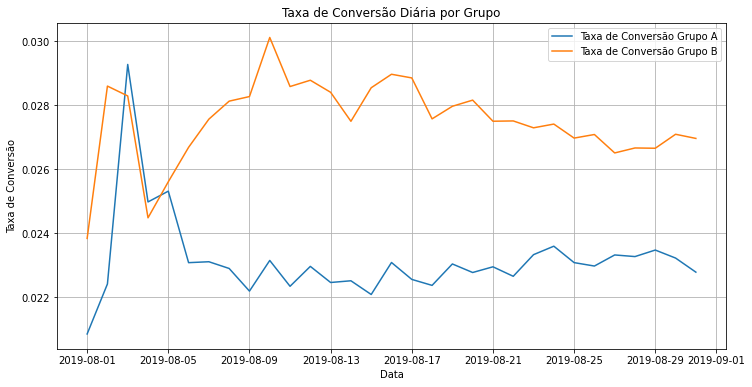

In [29]:
#Calculando a taxa de conversão para o grupo A
cumulativeDataA['conversion_rate'] = cumulativeDataA['orders'] / cumulativeData['visits']

#Calculando a taxa de conversão para o grupo B
cumulativeDataB['conversion_rate'] = cumulativeDataB['orders'] / cumulativeData['visits']

#Criando um gráfico para visualizar as taxas de conversão ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion_rate'], label='Taxa de Conversão Grupo A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion_rate'], label='Taxa de Conversão Grupo B')
plt.xlabel('Data')
plt.ylabel('Taxa de Conversão')
plt.title('Taxa de Conversão Diária por Grupo')
plt.legend()
plt.grid(True)
plt.show()

O gráfico indica variações nas taxas de conversão diárias para ambos os grupos. As taxas de conversão flutuam de um dia para outro.

Podemos observar como o grupo B se compara ao grupo A em termos de taxa de conversão, no inicio do periodo as taxas de converção foram semelhantes, porém a partir do dia 04/08 o grupo B teve um aumento grande na conversão, enquanto o grupo A continuou caindo.

Após isso o grupo A manteve uma média baixa em relação ao grupo B, que cresceu e conseguiu manter uma média maior.

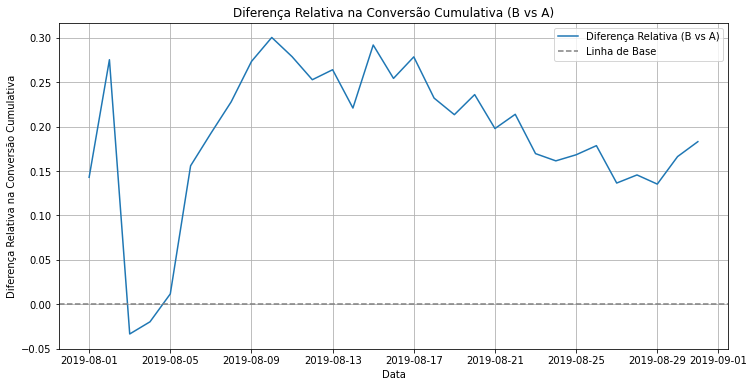

In [30]:
#Calculando a conversão cumulativa para o grupo A
cumulativeDataA['cumulative_conversion_A'] = cumulativeDataA['orders'] / cumulativeData['visits']

#Calculando a conversão cumulativa para o grupo B
cumulativeDataB['cumulative_conversion_B'] = cumulativeDataB['orders'] / cumulativeData['visits']

#Calculando a diferença relativa
cumulativeDataDiff = cumulativeDataA.merge(cumulativeDataB, on='date', suffixes=('_A', '_B'))
cumulativeDataDiff['relative_difference'] = (cumulativeDataDiff['cumulative_conversion_B'] / cumulativeDataDiff['cumulative_conversion_A']) - 1

#Criando um gráfico da diferença relativa na conversão cumulativa para o grupo B em comparação com o grupo A
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataDiff['date'], cumulativeDataDiff['relative_difference'], label='Diferença Relativa (B vs A)')
plt.axhline(y=0, color='gray', linestyle='--', label='Linha de Base')
plt.xlabel('Data')
plt.ylabel('Diferença Relativa na Conversão Cumulativa')
plt.title('Diferença Relativa na Conversão Cumulativa (B vs A)')
plt.legend()
plt.grid(True)
plt.show()

No geral, o gráfico acima mostra que a diferença da conversão cumulativa entra B e A é bem alta.

Houve uma queda brusca no dia 02/08, mas no dia 03/08, como podemos ver no gráfico, a diferença foi só aumentando chegando no seu auge no dia 10/08. 

Depois disso a diferença foi diminuindo um pouco mas manteve uma boa média.

Isso significa que as estratégias aplicadas no grupo B são comprovadamente eficazes. 

Agora irei calcular os percentis 95 e 99 para o número de pedidos por usuário. O ponto de dados se torna uma anomalia se o número de pedidos por usuário exceder o valor do percentil 99. 

In [31]:
#Agrupando os dados por 'visitorId' e contando o número de pedidos para cada usuário
orders_per_user = df_orders.groupby('visitorId')['transactionId'].count()

#Calculando os percentis 95 e 99
percentile_95 = orders_per_user.quantile(0.95)
percentile_99 = orders_per_user.quantile(0.99)

print("Percentil 95:", percentile_95)
print("Percentil 99:", percentile_99)

#Definindo um ponto de dados como anomalia com base nos percentis
anomaly_threshold = percentile_99  #podemos escolher outro limite, se necessário
anomalies = orders_per_user[orders_per_user > anomaly_threshold]

print("Número de Anomalias:", len(anomalies))
print("Usuários Anômalos:", anomalies)

Percentil 95: 1.0
Percentil 99: 1.0
Número de Anomalias: 0
Usuários Anômalos: Series([], Name: transactionId, dtype: int64)


Quando o percentil é 1.0, significa que 100% dos valores no conjunto de dados estão abaixo desse valor. Isso quer dizer que nenhum valor está acima do percentil 99 (ou seja, nenhum valor está nos 1% superiores dos dados). Portanto, não há anomalias identificadas com base nos percentis 95 e 99.

Isso pode ser interpretado como uma boa notícia, indicando que a maioria dos usuários faz um número razoável de pedidos, sem valores extremamente altos que seriam considerados anomalias. Em resumo, nosso conjunto de dados parece ser homogêneo em relação ao número de pedidos por usuário, sem outliers significativos.

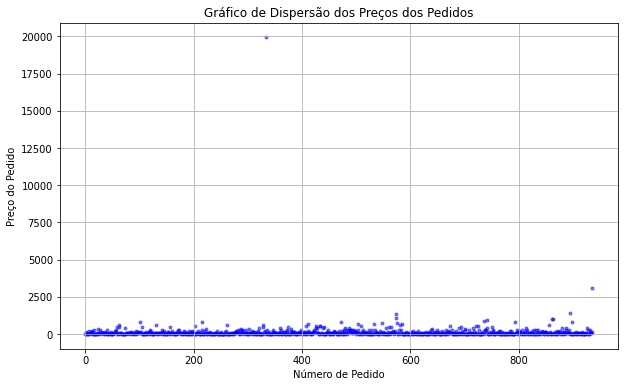

In [32]:
#Criando um gráfico de dispersão dos preços dos pedidos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df_orders)), df_orders['revenue'], marker='.', color='b', alpha=0.5)
plt.title('Gráfico de Dispersão dos Preços dos Pedidos')
plt.xlabel('Número de Pedido')
plt.ylabel('Preço do Pedido')
plt.grid(True)
plt.show()

Os preços dos pedidos variam amplamente, o que é esperado em uma loja online. Alguns pedidos têm preços muito baixos, enquanto outros têm preços consideravelmente mais altos.

Existem pouquissimos outliers óbvios no gráfico, o que sugere que praticamente não há pedidos com preços extraordinariamente altos que diferem significativamente da maioria.

Com base na dispersão dos preços dos pedidos, pode ser interessante segmentar os clientes com base em seus hábitos de compra, como clientes regulares que fazem pedidos de baixo valor e clientes ocasionais que fazem pedidos de alto valor.

Entender da variação nos preços dos pedidos pode ser útil na criação de estratégias de preços, como oferecer descontos diferenciados para clientes com diferentes comportamentos de compra.

In [33]:
#Calculando os percentis 95 e 99 dos preços dos pedidos
percentile_revenue_95 = df_orders['revenue'].quantile(0.95)
percentile_revenue_99 = df_orders['revenue'].quantile(0.99)

print("Percentil 95:", percentile_95)
print("Percentil 99:", percentile_99)

#Definindo um ponto de dados como anomalia com base nos percentis
revenue_anomaly_threshold = percentile_revenue_99  #podemos escolher outro limite, se necessário
revenue_anomalies = df_orders[df_orders['revenue'] > revenue_anomaly_threshold]

print("Número de Anomalias:", len(revenue_anomalies))
print("Pedidos Anômalos:", revenue_anomalies)

Percentil 95: 1.0
Percentil 99: 1.0
Número de Anomalias: 9
Pedidos Anômalos:       transactionId   visitorId       date  revenue group
425       590470918  1920142716 2019-08-19  19920.4     B
743      3603576309  4133034833 2019-08-09   1050.0     A
744      3668308183   888512513 2019-08-27   1335.6     B
940      2420050534  4003628586 2019-08-08    905.8     B
949      1347999392   887908475 2019-08-21    930.0     A
1099      316924019   148427295 2019-08-12   1015.9     A
1103     1348774318  1164614297 2019-08-12   1025.8     A
1136      666610489  1307669133 2019-08-13   1425.8     A
1196     3936777065  2108080724 2019-08-15   3120.1     B


Em resumo, a análise dos percentis e a identificação de anomalias nos preços dos pedidos podem ajudar na detecção de pedidos fora do comum e na tomada de decisões com base em dados significativos. É importante lembrar que nem todas as anomalias são necessariamente problemas; algumas podem ser pedidos de alto valor de clientes legítimos. Portanto, a análise deve ser usada para orientar a investigação e as ações apropriadas, se necessário.

Vamos encontrar a significância estatística da diferença na conversão entre os grupos usando os dados brutos, irei realizar um teste de hipótese, o teste t de Student. O objetivo é determinar se a diferença nas médias de conversão entre os grupos é estatisticamente significativa. 

Agora irei criar um dataframe "df_brute" utilizando os dados brutos e com uma coluna com a taxa de conversão de cada pedido.
Depois irei usa-lo para realizar alguns testes estatisticos.

In [34]:
#Juntando os dataframes df_orders e df_visits pela coluna 'date' e 'group'
df_brute = df_orders.merge(df_visits, on=['date', 'group'], how='inner')

#Criando uma coluna 'conversion_rate' com a taxa de conversão (pedidos/visitas)
df_brute['conversion_rate'] = df_brute['transactionId'] / df_brute['visits']

df_brute.head()

,transactionId,visitorId,date,revenue,group,visits,conversion_rate
0,3667963787,3312258926,2019-08-15,30.4,B,544,6.742580e+06
1,2804400009,3642806036,2019-08-15,15.2,B,544,5.155147e+06
2,3797467345,1196621759,2019-08-15,155.1,B,544,6.980639e+06
3,2282983706,2322279887,2019-08-15,40.5,B,544,4.196661e+06
4,182168103,935554773,2019-08-15,35.0,B,544,3.348678e+05


In [35]:
# Separar os dados brutos em grupos A e B
group_conversion_brute_A = df_brute[df_brute['group'] == 'A']['conversion_rate']
group_conversion_brute_B = df_brute[df_brute['group'] == 'B']['conversion_rate']

# Realizar o teste t de Student independente
t_statistic, p_value = stats.ttest_ind(group_conversion_brute_A, group_conversion_brute_B, equal_var=False)

print(f"Estatística t: {t_statistic}")
print(f"Valor p: {p_value}")

# Definir um nível de significância
alpha = 0.05

if p_value < alpha:
    print("Diferença estatisticamente significativa: rejeitar a hipótese nula")
else:
    print("Não há diferença estatisticamente significativa: Não rejeitar a hipótese nula")

Estatística t: -0.21195481137649358
Valor p: 0.8321901874925708
Não há diferença estatisticamente significativa: Não rejeitar a hipótese nula


O valor p de 0.83219, que é maior que o nível de significância comum de 0.05 (ou 5%), então não há evidência estatística para rejeitar a hipótese nula. Portanto, não podemos afirmar que existe uma diferença estatisticamente significativa na conversão entre os grupos A e B. Ou seja os dados BRUTOS não fornecem evidências sólidas de que a mudança nos grupos resultou em uma diferença substancial nas taxas de conversão.

In [36]:
#Separand os dados brutos em grupos A e B
group_revenue_brute_A = df_brute[df_brute['group'] == 'A']['revenue']
group_revenue_brute_B = df_brute[df_brute['group'] == 'B']['revenue']

#Realizando o teste t de Student independente
t_statistic, p_value = stats.ttest_ind(group_revenue_brute_A, group_revenue_brute_B, equal_var=False)

print(f"Estatística t: {t_statistic}")
print(f"Valor p: {p_value}")

#Definindo um nível de significância
alpha = 0.05

if p_value < alpha:
    print("Diferença estatisticamente significativa: rejeitar a hipótese nula")
else:
    print("Não há diferença estatisticamente significativa: Não rejeitar a hipótese nula")

Estatística t: -0.9182288488059823
Valor p: 0.3588989378189419
Não há diferença estatisticamente significativa: Não rejeitar a hipótese nula


Com base no valor p de 0.35890, que é maior que o nível de significância comum de 0.05 (ou 5%), não há evidência estatística para rejeitar a hipótese nula. 

Ou seja, não podemos afirmar que existe uma diferença estatisticamente significativa no tamanho médio do pedido entre os grupos A e B. 

Em outras palavras, os dados BRUTOS não fornecem evidências sólidas de que a mudança (se houver) nos grupos resultou em uma diferença substancial nos tamanhos médios dos pedidos.

Agora vamos realizar os testes utilizando os dados filtrados de cumulativeData

In [37]:
#Criando a coluna 'conversion_rate' com a taxa de conversão em cumulativeData
cumulativeData['conversion_rate'] = cumulativeData['orders'] / cumulativeData['visits']

In [38]:
#Filtrar os dados de cumulativeData para os grupos A e B
group_conversion_filtred_A = cumulativeData[cumulativeData['group'] == 'A']['conversion_rate']
group_conversion_filtred_B = cumulativeData[cumulativeData['group'] == 'B']['conversion_rate']

# Realizar o teste t de Student independente
t_statistic, p_value = stats.ttest_ind(group_conversion_filtred_A, group_conversion_filtred_B, equal_var=False)

print(f"Estatística t: {t_statistic}")
print(f"Valor p: {p_value}")

# Definir um nível de significância
alpha = 0.05

if p_value < alpha:
    print("Diferença estatisticamente significativa: rejeitar a hipótese nula")
else:
    print("Não há diferença estatisticamente significativa: falha em rejeitar a hipótese nula")

Estatística t: -12.838275358097565
Valor p: 8.089089923308357e-19
Diferença estatisticamente significativa: rejeitar a hipótese nula


Com base no valor p muito baixo, podemos rejeitar a hipótese nula. 
Portanto, há evidências estatísticas para concluir que a diferença na conversão entre os grupos A e B é estatisticamente significativa. 

Em outras palavras, a mudança realizada (se houver) nos grupos teve um impacto estatisticamente significativo na taxa de conversão.

In [39]:
#Separando os dados de cumulativeData para os grupos A e B
group_revenue_filtered_A = cumulativeData[cumulativeData['group'] == 'A']['revenue']
group_revenue_filtered_B = cumulativeData[cumulativeData['group'] == 'B']['revenue']

# Realizar o teste t de Student independente
t_statistic, p_value = stats.ttest_ind(group_revenue_filtered_A, group_revenue_filtered_B, equal_var=False)

print(f"Estatística t: {t_statistic}")
print(f"Valor p: {p_value}")

# Definir um nível de significância
alpha = 0.05

if p_value < alpha:
    print("Diferença estatisticamente significativa: rejeitar a hipótese nula")
else:
    print("Não há diferença estatisticamente significativa: falha em rejeitar a hipótese nula")

Estatística t: -2.5597890475745695
Valor p: 0.013681146439596897
Diferença estatisticamente significativa: rejeitar a hipótese nula


Com base no valor p de 0.01368, que é menor do que o nível de significância comum de 0.05 (ou 5%), podemos rejeitar a hipótese nula. Portanto, há evidências estatísticas para concluir que a diferença no tamanho médio do pedido entre os grupos A e B é estatisticamente significativa.

# Conclusão

Com base nas hipóteses testadas e nos gráficos apresentados, concluo que existe diferença no tamanho médio dos pedidos e também na taxa de conversão entre os grupos. 

Acredito que ambos os grupos estão tendo resultados positivos, com crescimento constante. 

Contudo, o grupo B apresentou melhorias muito significativas, sendo considerado líder em relação ao grupo A.  

Eu sugiro que as estratégias aplicadas no grupo B, sejam aplicadas em toda opeção. Acredito que assim a loja terá resultados cada vez mais positivos.
